In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import re
import shutil
import pandas as pd
import scipy.stats
import statsmodels
import seaborn as sns
import exdir
import expipe
from distutils.dir_util import copy_tree
# import septum_mec
import spatial_maps as sp
import head_direction.head as head
import septum_mec.analysis.data_processing as dp
import septum_mec.analysis.registration
from septum_mec.analysis.plotting import violinplot, savefig, despine

from spike_statistics.core import permutation_resampling_test, block_bootstrap

from tqdm.notebook import tqdm
tqdm.pandas()

In [3]:
project_path = dp.project_path()
project = expipe.get_project(project_path)
actions = project.actions

output_path = pathlib.Path("output") / "comparisons-gridcells"
(output_path / "statistics").mkdir(exist_ok=True, parents=True)
(output_path / "figures").mkdir(exist_ok=True, parents=True)

# Load cell statistics and shuffling quantiles

In [4]:
statistics_action = actions['calculate-statistics']
identification_action = actions['identify-neurons']
sessions = pd.read_csv(identification_action.data_path('sessions'))
units = pd.read_csv(identification_action.data_path('units'))
session_units = pd.merge(sessions, units, on='action')
statistics_results = pd.read_csv(statistics_action.data_path('results'))
statistics = pd.merge(session_units, statistics_results, how='left')
statistics.head()

,action,baseline,entity,frequency,i,ii,session,stim_location,stimulated,tag,...,gridness,border_score,information_rate,information_specificity,head_mean_ang,head_mean_vec_len,spacing,orientation,field_area,theta_score
0,1849-060319-3,True,1849,NaN,False,True,3,NaN,False,baseline ii,...,-0.466836,0.029328,1.009215,0.317256,5.438033,0.040874,0.628784,69.775141,0.412306,-0.430279
1,1849-060319-3,True,1849,NaN,False,True,3,NaN,False,baseline ii,...,-0.666792,0.308146,0.192524,0.033447,1.951740,0.017289,0.789388,62.102729,0.432396,0.307692
2,1849-060319-3,True,1849,NaN,False,True,3,NaN,False,baseline ii,...,-0.571614,0.143252,4.745836,0.393704,4.439721,0.124731,0.555402,61.189206,0.468221,-0.059705
3,1849-060319-3,True,1849,NaN,False,True,3,NaN,False,baseline ii,...,-0.428802,0.268948,0.157394,0.073553,6.215195,0.101911,0.492250,4.969741,0.425901,0.132632
4,1849-060319-3,True,1849,NaN,False,True,3,NaN,False,baseline ii,...,-0.083406,0.218744,0.519153,0.032683,1.531481,0.053810,0.559905,0.000000,0.395395,0.218721


In [5]:
shuffling = actions['shuffling']
quantiles_95 = pd.read_csv(shuffling.data_path('quantiles_95'))
quantiles_95.head()

,border_score,gridness,head_mean_ang,head_mean_vec_len,information_rate,speed_score,action,channel_group,unit_name
0,0.348023,0.275109,3.012689,0.086792,0.707197,0.149071,1833-010719-1,0.0,127.0
1,0.362380,0.166475,3.133138,0.037271,0.482486,0.132212,1833-010719-1,0.0,161.0
2,0.367498,0.266865,5.586395,0.182843,0.271188,0.062821,1833-010719-1,0.0,191.0
3,0.331942,0.312155,5.955767,0.090786,0.354018,0.052009,1833-010719-1,0.0,223.0
4,0.325842,0.180495,5.262721,0.103584,0.210427,0.094041,1833-010719-1,0.0,225.0


In [6]:
action_columns = ['action', 'channel_group', 'unit_name']
data = pd.merge(statistics, quantiles_95, on=action_columns, suffixes=("", "_threshold"))

data['specificity'] = np.log10(data['in_field_mean_rate'] / data['out_field_mean_rate'])

data.head()

,action,baseline,entity,frequency,i,ii,session,stim_location,stimulated,tag,...,orientation,field_area,theta_score,border_score_threshold,gridness_threshold,head_mean_ang_threshold,head_mean_vec_len_threshold,information_rate_threshold,speed_score_threshold,specificity
0,1849-060319-3,True,1849,NaN,False,True,3,NaN,False,baseline ii,...,69.775141,0.412306,-0.430279,0.332548,0.229073,6.029431,0.205362,1.115825,0.066736,0.451741
1,1849-060319-3,True,1849,NaN,False,True,3,NaN,False,baseline ii,...,62.102729,0.432396,0.307692,0.354830,0.089333,6.120055,0.073566,0.223237,0.052594,0.098517
2,1849-060319-3,True,1849,NaN,False,True,3,NaN,False,baseline ii,...,61.189206,0.468221,-0.059705,0.264610,-0.121081,5.759406,0.150827,4.964984,0.027120,0.400770
3,1849-060319-3,True,1849,NaN,False,True,3,NaN,False,baseline ii,...,4.969741,0.425901,0.132632,0.344280,0.215829,6.033364,0.110495,0.239996,0.054074,0.269461
4,1849-060319-3,True,1849,NaN,False,True,3,NaN,False,baseline ii,...,0.000000,0.395395,0.218721,0.342799,0.218967,5.768170,0.054762,0.524990,0.144702,0.133410


# Statistics about all cell-sessions

In [7]:
data.groupby('stimulated').count()['action']

stimulated
False    624
True     660
Name: action, dtype: int64

In [8]:
data['unit_day'] = data.apply(lambda x: str(x.unit_idnum) + '_' + x.action.split('-')[1], axis=1)

# Find all cells with gridness above threshold

In [9]:
query = (
    'gridness > gridness_threshold and '
    'information_rate > information_rate_threshold and '
    'gridness > .2 and '
    'average_rate < 25'
)
sessions_above_threshold = data.query(query)
print("Number of sessions above threshold", len(sessions_above_threshold))
print("Number of animals", len(sessions_above_threshold.groupby(['entity'])))

Number of sessions above threshold 194
Number of animals 4


In [10]:
gridcell_sessions = data[data.unit_day.isin(sessions_above_threshold.unit_day.values)]

In [11]:
print("Number of gridcells", gridcell_sessions.unit_idnum.nunique())
print("Number of gridcell recordings", len(gridcell_sessions))
print("Number of animals", len(gridcell_sessions.groupby(['entity'])))

Number of gridcells 139
Number of gridcell recordings 230
Number of animals 4


In [12]:
baseline_i = gridcell_sessions.query('baseline and Hz11 and i')
stimulated_11 = gridcell_sessions.query('frequency==11 and stim_location=="ms"')

baseline_ii = gridcell_sessions.query('baseline and Hz30 and ii')
stimulated_30 = gridcell_sessions.query('frequency==30 and stim_location=="ms"')

print("Number of gridcells in baseline i sessions", len(baseline_i))
print("Number of gridcells in stimulated 11Hz ms sessions", len(stimulated_11))

print("Number of gridcells in baseline ii sessions", len(baseline_ii))
print("Number of gridcells in stimulated 30Hz ms sessions", len(stimulated_30))

Number of gridcells in baseline i sessions 66
Number of gridcells in stimulated 11Hz ms sessions 61
Number of gridcells in baseline ii sessions 51
Number of gridcells in stimulated 30Hz ms sessions 40


# slice unique units

In [13]:
baseline_i = baseline_i.drop_duplicates('unit_id')
stimulated_11 = stimulated_11.drop_duplicates('unit_id')
baseline_ii = baseline_ii.drop_duplicates('unit_id')
stimulated_30 = stimulated_30.drop_duplicates('unit_id')

In [14]:
print("Number of gridcells in baseline i sessions", len(baseline_i))
print("Number of gridcells in stimulated 11Hz ms sessions", len(stimulated_11))

print("Number of gridcells in baseline ii sessions", len(baseline_ii))
print("Number of gridcells in stimulated 30Hz ms sessions", len(stimulated_30))

Number of gridcells in baseline i sessions 63
Number of gridcells in stimulated 11Hz ms sessions 58
Number of gridcells in baseline ii sessions 49
Number of gridcells in stimulated 30Hz ms sessions 38


In [15]:
colors = ['#1b9e77','#d95f02','#7570b3','#e7298a']
labels = ['Baseline I', '11 Hz', 'Baseline II', '30 Hz']
queries = ['baseline and i and Hz11', 'frequency==11 and stim_location=="ms"', 'baseline and ii and Hz30', 'frequency==30 and stim_location=="ms"']

# Calculate statistics

In [16]:
columns = [
    'average_rate', 'gridness', 'sparsity', 'selectivity', 'information_specificity',
    'max_rate', 'information_rate', 'interspike_interval_cv', 
    'in_field_mean_rate', 'out_field_mean_rate', 
    'burst_event_ratio', 'specificity', 'speed_score', 'spacing', 'field_area', 'theta_score'
]

In [17]:
results = {}
for key in columns:
    results[key] = list()
    for query, label in zip(queries, labels):
        values = gridcell_sessions.query(query).loc[:,['entity', 'unit_idnum', 'date', key]]
        results[key].append(values.rename({key: label}, axis=1))

In [18]:
from functools import reduce
for key, val in results.items():
    df = reduce(lambda  left, right: pd.merge(left, right, on=['entity', 'unit_idnum', 'date'], how='outer'), val)
    results[key] = df#.drop('unit_day',axis=1)

In [19]:
results['spacing'].sort_values('entity')

,entity,unit_idnum,date,Baseline I,11 Hz,Baseline II,30 Hz
0,1833,30,260619,0.333416,NaN,0.370479,NaN
106,1833,284,290519,NaN,NaN,0.384464,NaN
104,1833,128,10719,NaN,0.354793,NaN,NaN
103,1833,124,10719,NaN,0.357032,NaN,NaN
102,1833,55,10719,NaN,0.358831,NaN,NaN
...,...,...,...,...,...,...,...
73,1849,724,280219,NaN,0.968465,NaN,0.473208
69,1849,684,220319,NaN,0.522694,NaN,NaN
65,1849,932,280219,0.581307,NaN,NaN,NaN
139,1849,835,150319,NaN,NaN,NaN,0.533441


In [20]:
results['spacing'].drop_duplicates('unit_idnum')

,entity,unit_idnum,date,Baseline I,11 Hz,Baseline II,30 Hz
0,1833,30,260619,0.333416,NaN,0.370479,NaN
1,1833,31,260619,0.368563,NaN,0.362060,0.361666
2,1833,32,260619,0.351924,0.342142,0.355808,0.371447
3,1833,78,260619,0.358140,NaN,NaN,NaN
4,1833,79,260619,0.375787,0.361430,NaN,NaN
...,...,...,...,...,...,...,...
142,1833,274,260619,NaN,NaN,NaN,0.347304
143,1833,275,260619,NaN,NaN,NaN,0.352491
144,1833,248,120619,NaN,NaN,NaN,0.374918
145,1833,249,120619,NaN,NaN,NaN,0.379029


In [21]:
def drop_duplicates_least_null(df, key):
    return df.loc[df.notnull().sum(1).groupby(df[key]).idxmax()]

In [22]:
for key, val in results.items():
    results[key] = drop_duplicates_least_null(val, 'unit_idnum')

In [68]:
from septum_mec.analysis.statistics import make_bootstrap_table, bootstrap_results, make_paired_table, power, bootstrap_pvalue, compute_weighted_mean_sem

# testing

In [25]:
# ps = power(results['gridness'], 'Baseline I', '11 Hz', .1)

In [164]:
scipy.stats.ttest_ind(
    results['gridness'].loc[:, 'Baseline I'].dropna(), 
    results['gridness'].loc[:, '11 Hz'].dropna()
)

Ttest_indResult(statistic=2.01153977780326, pvalue=0.04656653210296542)

In [167]:
scipy.stats.wilcoxon(
    *results['gridness'].loc[:, ['Baseline I', '11 Hz']].dropna().values.T
)

WilcoxonResult(statistic=92.0, pvalue=0.4140400034242331)

In [171]:
bootstrap_pvalue(results['gridness'], 'Baseline I', '11 Hz', n_boots=100, n_samples=10, n_blocks=4, delta=.1)

(100, 40)


(0.89,
 -0.2376475235285581,
 0.4705002562838838,
 0.85,
 0.4723343292575506,
 0.8931906210078713)

In [129]:
pss = [bootstrap_pvalue(results['gridness'], 'Baseline I', '11 Hz', n_boots=100, n_samples=10, n_blocks=4, delta=0.2) for _ in range(100)]

In [130]:
np.mean(pss)

0.3858

In [450]:
results['gridness'].entity = results['gridness'].entity.values.astype(int)

In [452]:
results['gridness'].

51     1833
85     1833
86     1833
58     1833
127    1833
       ... 
139    1849
43     1849
65     1849
74     1849
105    1849
Name: entity, Length: 137, dtype: int64

In [31]:
control, case = 'Baseline I', '11 Hz'

In [41]:
group = results['gridness'].loc[:, ['entity', control, case]].groupby('entity')

In [59]:
group.sample(n=group.size().min())

8

In [62]:
for i, grp in group:
    print(grp)
    break

     entity  Baseline I     11 Hz
51     1833    0.782658       NaN
85     1833         NaN -0.223869
86     1833         NaN  0.048667
58     1833    0.390350       NaN
127    1833         NaN       NaN
..      ...         ...       ...
83     1833         NaN  0.200427
117    1833         NaN       NaN
64     1833    0.317431  0.346084
35     1833   -0.162584       NaN
109    1833         NaN       NaN

[94 rows x 3 columns]


In [75]:
def block_permutation_resampling_test(data, groupby, case, control, n_blocks=100, n_samples=1000, statistic=np.mean):
    group = data.loc[:, [groupby, control, case]].groupby(groupby)
    case_mean, _, _ = compute_weighted_mean_sem(data, case, groupby)
    control_mean, _, _ = compute_weighted_mean_sem(data, control, groupby)
    obs_diff = abs(case_mean - control_mean)
    boot_samples = []
    for _ in np.arange(n_blocks):
        group_sample = group.sample(n=group.size().min()).groupby(groupby)
        for idx, subgroup in group_sample:
            combined = np.concatenate([
                subgroup[case].dropna().values,
                subgroup[control].dropna().values
            ])
            num_case = subgroup[case].count()
            diffs = []
            for i in range(n_samples):
                xs = np.random.permutation(combined)
                diff = statistic(xs[:num_case]) - statistic(xs[num_case:])
                diffs.append(diff)
            boot_samples.extend(diffs)
    pvalue = np.mean(np.abs(boot_samples) >= obs_diff)
    return pvalue, obs_diff, np.array(boot_samples)

In [76]:
pval, effect_size, diffs = block_permutation_resampling_test(results['gridness'], 'entity', case, control)

/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [78]:
pval, effect_size

(0.89382, 0.03346686678941169)

(array([1.88300e+03, 2.69310e+04, 4.71620e+04, 7.26790e+04, 1.17182e+05,
        8.43080e+04, 2.70750e+04, 1.41270e+04, 6.57600e+03, 7.70000e+01]),
 array([-0.82398742, -0.63529861, -0.44660981, -0.257921  , -0.06923219,
         0.11945661,  0.30814542,  0.49683423,  0.68552303,  0.87421184,
         1.06290065]),
 <a list of 10 Patch objects>)

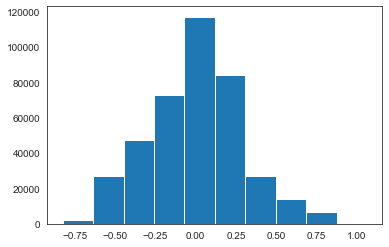

In [77]:
plt.hist(diffs)

In [84]:
def block_bootstrap_pvalue(data, groupby, case, control, n_blocks=100, n_samples=1000, statistic=np.mean, alpha=0.05):
    group = data.loc[:, [groupby, control, case]].groupby(groupby)
        
    case_mean, _, _ = compute_weighted_mean_sem(data, case, groupby)
    control_mean, _, _ = compute_weighted_mean_sem(data, control, groupby)
    emp_diff_means = abs(case_mean - control_mean)
    
    bs_replicates = []
    for _ in range(n_samples):
        group_sample = group.sample(n=n_blocks, replace=True)
        diff = statistic(group_sample[case]) - statistic(group_sample[control])
        bs_replicates.append(diff)
    bs_replicates = np.array(bs_replicates)
    
    bs_replicates_shifted = bs_replicates - bs_replicates.mean()
    emp_diff_pctile_rnk = scipy.stats.percentileofscore(bs_replicates_shifted, emp_diff_means)
    
    auc_left = emp_diff_pctile_rnk / 100
    auc_right = 1 - auc_left
    pval = min([auc_left, auc_right]) * 2
    
    low, high = np.percentile(bs_replicates, [(alpha / 2.0) * 100, (1 - alpha / 2.0) * 100])
    
    return pval, low, high, bs_replicates

In [85]:
pval, low, high, bs_replicates = block_bootstrap_pvalue(results['gridness'], 'entity', case, control)

In [87]:
pval, low, high

(0.42599999999999993, -0.08160693000989326, 0.09060868881049337)

(array([ 10.,  43., 110., 220., 267., 217.,  92.,  36.,   4.,   1.]),
 array([-0.12323001, -0.09444247, -0.06565493, -0.03686739, -0.00807985,
         0.02070769,  0.04949522,  0.07828276,  0.1070703 ,  0.13585784,
         0.16464538]),
 <a list of 10 Patch objects>)

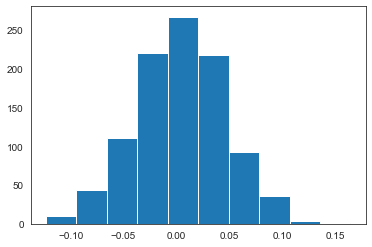

In [88]:
plt.hist(bs_replicates)

# compare methods on Gaussian data

In [138]:
import scipy.stats as ss

In [172]:
a = ss.norm(loc=0, scale=1.)
b = ss.norm(loc=1.2, scale=1.)

In [181]:
ps = [ss.ttest_ind(a.rvs(10), b.rvs(10)).pvalue for _ in range(1000)]

In [182]:
np.mean(np.array(ps) < 0.05)

0.727

In [207]:
permute_ps = [permutation_resampling_test(a.rvs(10), b.rvs(10), num_samples=1000)[0] for _ in tqdm(range(1000))]

KeyboardInterrupt: 

In [201]:
np.mean(np.array(permute_ps) < 0.05)

0.711

In [340]:
anum, bnum = a.rvs(10), b.rvs(10)
permutation_resampling_test(anum, bnum, num_samples=10000)[0], ss.ttest_ind(anum, bnum).pvalue

(0.0285, 0.028416232492872454)

In [276]:
from spike_statistics.core import bootstrap

In [426]:
def compute_t_statistic(x, y, axis=0, weights=(None, None)):

    m, n = x.shape[axis], y.shape[axis]
    
    mx = np.average(x, axis=axis, weights=weights[0])
    my = np.average(y, axis=axis, weights=weights[1])
    
    sx = np.average((x.T - mx).T**2, axis=axis, weights=weights[0])
    sy = np.average((y.T - my).T**2, axis=axis, weights=weights[1])
    
    df = n + m - 2
    return (mx - my) / np.sqrt(((n * sx + m * sy) * (1 / n + 1 / m)) / df)

In [438]:
def bootstrap_pvalue(case, control, n_samples=10000, delta=0.0):
    '''
    pvalue from bootstrap results, shifts the sample distribution
    
    Examples
    import scipy.stats as ss
    a = ss.norm(loc=0, scale=1.)
    b = ss.norm(loc=1.2, scale=1.)
    anum, bnum = a.rvs(10), b.rvs(10)
    pval_ttest = ss.ttest_ind(anum, bnum).pvalue
    pval_bootstrap = bootstrap_pvalue(anum, bnum)
    '''
    
    pooled_mean = (sum(case) + sum(control)) / (len(case) + len(control))
    case_s = case - np.mean(case) + pooled_mean + delta
    control_s = control - np.mean(control) + pooled_mean
    
    # tstat
    case_boot = bootstrap(case_s, num_samples=n_samples, statistic=lambda x, axis:x)
    control_boot = bootstrap(control_s, num_samples=n_samples, statistic=lambda x, axis:x)
    
    T = compute_t_statistic(case_boot, control_boot, axis=1)
    t = compute_t_statistic(case, control)
    pval = (1 + np.sum(np.abs(T) > np.abs(t))) / (len(case_boot) + 1)
    
    return pval

In [439]:
def bootstrap_pvalue(case, control, n_samples=10000, delta=0.0, alpha=0.05, weights=(None, None)):
    '''
    pvalue from bootstrap results, shifts the sample distribution
    '''
    from statsmodels.stats.weightstats import ttest_ind
    
    pooled_mean = (sum(case) + sum(control)) / (len(case) + len(control))
    case_s = case - np.mean(case) + pooled_mean
    control_s = control - np.mean(control) + pooled_mean
    
#     case_boot = bootstrap(case_s + delta, num_samples=n_samples, statistic=np.mean)
#     control_boot = bootstrap(control_s, num_samples=n_samples, statistic=np.mean)

#     observed_diff = abs(np.mean(case) - np.mean(control))
    
    # direct
#     diffs = case_boot# - control_boot
#     low, high = np.percentile(diffs, [(alpha / 2.0) * 100, (1 - alpha / 2.0) * 100])
    
#     pval = (np.sum(np.abs(diffs) >= observed_diff) + 1) / (len(case_boot) + 1)
#     pval_ = (np.sum(diffs > observed_diff) + np.sum(diffs < - observed_diff)) / (len(case_boot))
    
    # tstat
    case_boot = bootstrap(case_s + delta, num_samples=n_samples, statistic=lambda x, axis:x)
    control_boot = bootstrap(control_s, num_samples=n_samples, statistic=lambda x, axis:x)
    
    T = compute_t_statistic(case_boot, control_boot, axis=1)
    t = compute_t_statistic(case, control, weights=weights)
    
    pval_1 = (1 + np.sum(np.abs(T) > np.abs(t))) / (len(case_boot) + 1)

#     T = scipy.stats.ttest_ind(case_boot, control_boot, axis=1, equal_var=False).statistic
#     t = scipy.stats.ttest_ind(case, control, equal_var=False).statistic
    
    T = [ttest_ind(a, b)[0] for a, b in zip(case_boot, control_boot)]
    t, _, _ = ttest_ind(case, control, weights=weights)
    
    pval_2 = (1 + np.sum(np.abs(T) > np.abs(t))) / (len(case_boot) + 1)
    
    return pval_1, pval_2

In [429]:
scipy.stats.ttest_ind(anum, bnum, equal_var=False).statistic - compute_t_statistic(anum, bnum)

-4.440892098500626e-16

In [443]:
t2 = statsmodels.stats.weightstats.ttest_ind(anum, bnum, weights=(np.ones_like(anum)/2, np.ones_like(bnum) / 4))[0]
t1 = compute_t_statistic(anum, bnum, weights=(np.ones_like(anum)/2, np.ones_like(bnum) / 4))
t1,t2

(-2.382714462916237, -1.2550452954437399)

In [441]:
bootstrap_pvalue(anum, bnum, weights=(np.ones_like(anum)/2, np.ones_like(bnum) / 4))

(0.030996900309969003, 0.22767723227677233)

In [374]:
%debug

> <ipython-input-371-0c32e6b40a6c>(12)compute_t_statistic()
      8     sx = np.average((x.T - mx)**2, axis=axis, weights=weights[0])
      9     sy = np.average((y.T - my)**2, axis=axis, weights=weights[1])
     10 
     11     df = n + m - 2
---> 12     return (mx - my) / np.sqrt(((n * sx + m * sy) * (1 / n + 1 / m)) / df)



ipdb>  mx


array([0.96055077, 0.83941918, 0.69370473, ..., 1.36351301, 0.88495778,
       0.56486075])


ipdb>  ms.shape


*** NameError: name 'ms' is not defined


ipdb>  mx.shape


(10000,)


ipdb>  my.shape


(10000,)


ipdb>  sx.shape


(10,)


ipdb>  exit


# Create nice table

In [49]:
bootstrapped_results = bootstrap_results(results, labels)

In [65]:
stat,_ = make_bootstrap_table(results, bootstrapped_results, labels)

In [66]:
stat.T

,Baseline I,11 Hz,Baseline II,30 Hz,Baseline I - 11 Hz,Baseline I - Baseline II,Baseline I - 30 Hz,11 Hz - Baseline II,11 Hz - 30 Hz,Baseline II - 30 Hz
Average rate,9.8e+00 ± 9.3e-01 (63),1.1e+01 ± 1.0e+00 (56),1.0e+01 ± 1.0e+00 (46),8.5e+00 ± 1.1e+00 (35),"4.7e-01 [-4.9e+00, 1.4e+00]","7.3e-01 [-4.8e+00, 3.0e+00]","5.4e-01 [-1.9e+00, 5.5e+00]","7.6e-01 [-3.7e+00, 4.1e+00]","2.3e-01 [-8.1e-01, 6.6e+00]","3.5e-01 [-1.3e+00, 6.1e+00]"
Gridness,3.7e-01 ± 5.6e-02 (63),4.0e-01 ± 5.1e-02 (56),5.3e-01 ± 3.7e-02 (46),5.7e-01 ± 4.9e-02 (35),"7.8e-01 [-2.2e-01, 1.5e-01]","5.0e-02 [-3.1e-01, 2.2e-02]","3.0e-02 [-4.1e-01, -2.0e-02]","1.4e-01 [-2.8e-01, 5.5e-02]","1.0e-01 [-3.8e-01, 1.4e-02]","6.6e-01 [-2.6e-01, 1.4e-01]"
Sparsity,6.6e-01 ± 2.4e-02 (63),7.1e-01 ± 3.1e-02 (56),6.6e-01 ± 3.2e-02 (46),6.4e-01 ± 3.7e-02 (35),"3.6e-01 [-1.4e-01, 6.5e-02]","9.5e-01 [-1.4e-01, 1.9e-01]","7.7e-01 [-9.5e-02, 1.6e-01]","4.6e-01 [-8.5e-02, 2.4e-01]","3.0e-01 [-4.4e-02, 2.1e-01]","8.0e-01 [-1.0e-01, 1.5e-01]"
Selectivity,5.3e+00 ± 4.3e-01 (63),5.4e+00 ± 5.9e-01 (56),6.2e+00 ± 6.7e-01 (46),6.8e+00 ± 6.7e-01 (35),"9.0e-01 [-2.0e+00, 1.5e+00]","6.1e-01 [-4.0e+00, 1.4e+00]","3.1e-01 [-4.3e+00, 7.9e-01]","6.5e-01 [-3.8e+00, 1.5e+00]","3.6e-01 [-4.2e+00, 9.3e-01]","6.9e-01 [-3.3e+00, 1.8e+00]"
Information specificity,2.5e-01 ± 3.4e-02 (63),2.2e-01 ± 4.5e-02 (56),2.3e-01 ± 3.4e-02 (46),2.4e-01 ± 3.8e-02 (35),"6.4e-01 [-1.2e-01, 1.5e-01]","7.2e-01 [-1.0e-01, 1.4e-01]","9.0e-01 [-2.1e-01, 1.3e-01]","8.5e-01 [-1.4e-01, 1.1e-01]","7.9e-01 [-2.4e-01, 9.8e-02]","9.0e-01 [-2.3e-01, 1.1e-01]"
Max rate,3.6e+01 ± 2.1e+00 (63),3.6e+01 ± 2.2e+00 (56),4.2e+01 ± 2.4e+00 (46),3.7e+01 ± 2.5e+00 (35),"1.0e+00 [-7.7e+00, 5.5e+00]","7.0e-02 [-1.4e+01, 7.0e-02]","8.2e-01 [-1.1e+01, 7.6e+00]","7.0e-02 [-1.4e+01, 2.6e-02]","8.0e-01 [-1.1e+01, 7.5e+00]","3.5e-01 [-5.0e+00, 1.4e+01]"
Information rate,1.4e+00 ± 8.6e-02 (63),9.3e-01 ± 6.9e-02 (56),1.3e+00 ± 1.0e-01 (46),1.1e+00 ± 1.1e-01 (35),"0.0e+00 [2.0e-01, 6.6e-01]","6.6e-01 [-4.7e-01, 4.3e-01]","2.8e-01 [-2.7e-01, 6.7e-01]","9.0e-02 [-9.0e-01, -7.0e-03]","3.1e-01 [-7.0e-01, 2.3e-01]","5.9e-01 [-3.6e-01, 5.7e-01]"
Interspike interval cv,2.2e+00 ± 8.9e-02 (63),2.0e+00 ± 1.4e-01 (56),2.2e+00 ± 8.0e-02 (46),2.3e+00 ± 1.1e-01 (35),"5.5e-01 [-3.2e-01, 5.9e-01]","8.4e-01 [-3.2e-01, 3.4e-01]","6.1e-01 [-4.9e-01, 2.1e-01]","3.6e-01 [-5.0e-01, 1.6e-01]","2.1e-01 [-6.7e-01, 2.9e-02]","5.1e-01 [-5.2e-01, 1.8e-01]"
In-field mean rate,1.5e+01 ± 1.2e+00 (63),1.6e+01 ± 1.3e+00 (56),1.7e+01 ± 1.2e+00 (46),1.3e+01 ± 1.3e+00 (35),"8.3e-01 [-4.7e+00, 3.6e+00]","4.6e-01 [-4.9e+00, 3.3e+00]","4.5e-01 [-4.1e+00, 7.0e+00]","6.3e-01 [-4.4e+00, 3.7e+00]","3.5e-01 [-3.6e+00, 7.5e+00]","1.8e-01 [-2.6e+00, 8.5e+00]"
Out-field mean rate,7.3e+00 ± 7.9e-01 (63),8.8e+00 ± 9.0e-01 (56),7.8e+00 ± 8.6e-01 (46),6.0e+00 ± 8.7e-01 (35),"3.6e-01 [-4.3e+00, 1.3e+00]","8.2e-01 [-4.1e+00, 2.8e+00]","4.2e-01 [-2.9e+00, 3.9e+00]","6.1e-01 [-2.7e+00, 4.3e+00]","7.0e-02 [-1.5e+00, 5.3e+00]","2.5e-01 [-2.5e+00, 4.3e+00]"


In [61]:
stat.T.to_latex(output_path / "statistics" / f"statistics.tex")
stat.T.to_csv(output_path / "statistics" / f"statistics.csv")

In [62]:
paired_stat = make_paired_table(results, labels)

paired_stat.T

,Normality Baseline I,Normality 11 Hz,Normality Baseline II,Normality 30 Hz,Wilcoxon Baseline I - 11 Hz,Wilcoxon Baseline I - Baseline II,Wilcoxon Baseline I - 30 Hz,Wilcoxon 11 Hz - Baseline II,Wilcoxon 11 Hz - 30 Hz,Wilcoxon Baseline II - 30 Hz
Average rate,"7.1e+00, 2.9e-02","5.1e+00, 7.7e-02","8.7e+00, 1.3e-02","8.1e+00, 1.7e-02","6.1e+01, 5.8e-02, (21)","4.9e+01, 5.3e-01, (15)","1.1e+01, 3.3e-01, (8)","3.9e+01, 1.3e-01, (16)","2.3e+01, 6.5e-01, (10)","6.1e+01, 7.2e-01, (16)"
Gridness,"1.3e+01, 1.5e-03","5.1e-01, 7.7e-01","4.9e+00, 8.5e-02","1.5e+00, 4.8e-01","9.2e+01, 4.1e-01, (21)","4.4e+01, 3.6e-01, (15)","6.0e+00, 9.3e-02, (8)","4.0e+01, 1.5e-01, (16)","2.5e+01, 8.0e-01, (10)","4.1e+01, 1.6e-01, (16)"
Sparsity,"6.6e+00, 3.6e-02","5.9e+00, 5.3e-02","5.5e+00, 6.5e-02","8.1e+00, 1.8e-02","4.8e+01, 1.9e-02, (21)","4.1e+01, 2.8e-01, (15)","1.0e+00, 1.7e-02, (8)","3.4e+01, 7.9e-02, (16)","1.3e+01, 1.4e-01, (10)","1.9e+01, 1.1e-02, (16)"
Selectivity,"1.8e+01, 1.1e-04","3.0e+01, 3.5e-07","2.8e+01, 7.6e-07","3.4e+00, 1.8e-01","9.4e+01, 4.5e-01, (21)","4.4e+01, 3.6e-01, (15)","1.1e+01, 3.3e-01, (8)","5.8e+01, 6.1e-01, (16)","9.0e+00, 5.9e-02, (10)","6.7e+01, 9.6e-01, (16)"
Information specificity,"4.4e+01, 3.4e-10","5.5e+01, 8.9e-13","1.7e+01, 1.9e-04","9.6e+00, 8.0e-03","3.4e+01, 4.6e-03, (21)","4.3e+01, 3.3e-01, (15)","9.0e+00, 2.1e-01, (8)","3.7e+01, 1.1e-01, (16)","1.3e+01, 1.4e-01, (10)","4.1e+01, 1.6e-01, (16)"
Max rate,"3.5e+00, 1.8e-01","6.0e-01, 7.4e-01","8.0e+00, 1.9e-02","7.7e-01, 6.8e-01","7.9e+01, 2.0e-01, (21)","3.4e+01, 1.4e-01, (15)","1.5e+01, 6.7e-01, (8)","2.4e+01, 2.3e-02, (16)","2.0e+00, 9.3e-03, (10)","4.8e+01, 3.0e-01, (16)"
Information rate,"6.1e+00, 4.6e-02","2.6e+01, 2.6e-06","1.3e+01, 1.4e-03","9.2e+00, 1.0e-02","1.6e+01, 5.4e-04, (21)","5.7e+01, 8.6e-01, (15)","2.0e+00, 2.5e-02, (8)","3.4e+01, 7.9e-02, (16)","2.0e+00, 9.3e-03, (10)","2.0e+01, 1.3e-02, (16)"
Interspike interval cv,"3.5e+01, 2.1e-08","4.6e+01, 1.2e-10","3.0e+00, 2.2e-01","1.8e+00, 4.1e-01","6.3e+01, 6.8e-02, (21)","3.5e+01, 1.6e-01, (15)","1.3e+01, 4.8e-01, (8)","8.0e+00, 1.9e-03, (16)","1.4e+01, 1.7e-01, (10)","3.0e+01, 4.9e-02, (16)"
In-field mean rate,"6.2e+00, 4.4e-02","4.6e+00, 1.0e-01","4.1e+00, 1.3e-01","5.0e+00, 8.0e-02","5.4e+01, 3.3e-02, (21)","4.1e+01, 2.8e-01, (15)","8.0e+00, 1.6e-01, (8)","2.6e+01, 3.0e-02, (16)","2.2e+01, 5.8e-01, (10)","3.6e+01, 9.8e-02, (16)"
Out-field mean rate,"9.5e+00, 8.7e-03","6.5e+00, 3.9e-02","1.6e+01, 4.3e-04","9.4e+00, 9.2e-03","7.7e+01, 1.8e-01, (21)","4.0e+01, 2.6e-01, (15)","1.8e+01, 1.0e+00, (8)","4.5e+01, 2.3e-01, (16)","2.6e+01, 8.8e-01, (10)","6.8e+01, 1.0e+00, (16)"


In [63]:
paired_stat.T.to_latex(output_path / "statistics" / f"paired-statistics.tex")
paired_stat.T.to_csv(output_path / "statistics" / f"paired-statistics.csv")

In [64]:
for key, result in results.items():
    result.to_latex(output_path / "statistics" / f"values_{key}.tex")
    result.to_csv(output_path / "statistics" / f"values_{key}.csv")

## Cumulative density plots

In [32]:
import matplotlib
plt.rc('axes', titlesize=12)
plt.rcParams.update({
    'font.size': 12, 
    'figure.figsize': (3.7, 2.2), 
    'figure.dpi': 150
})

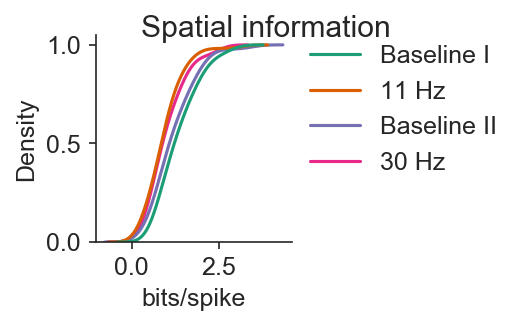

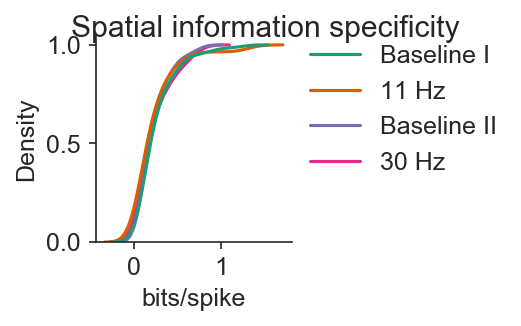

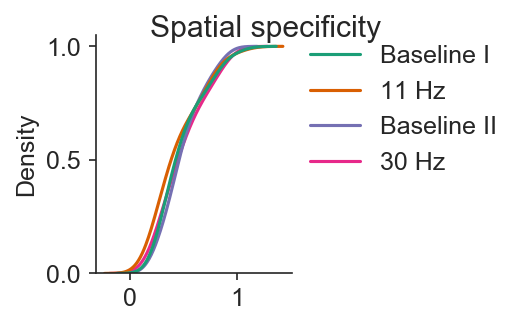

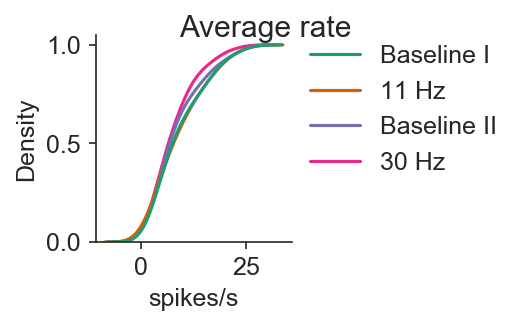

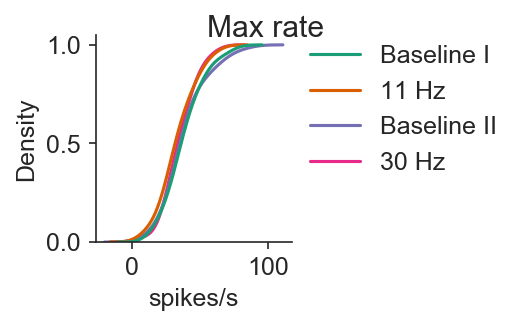

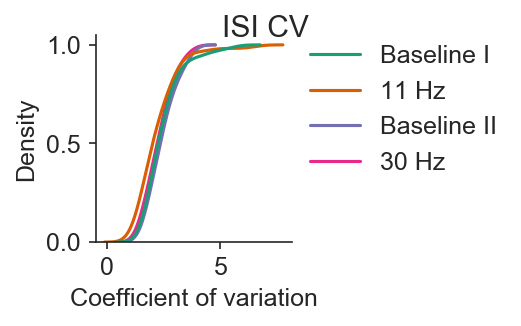

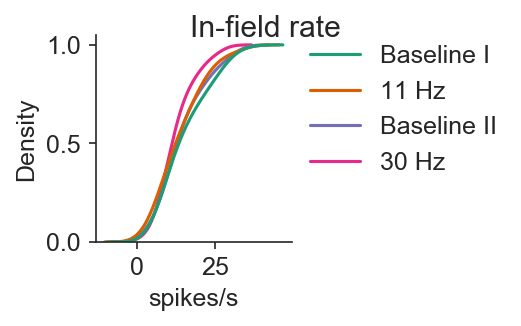

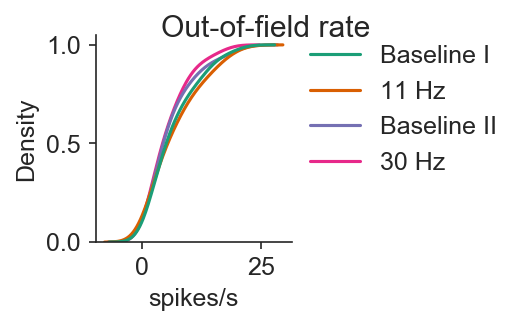

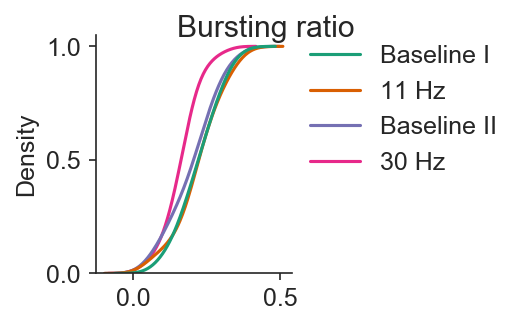

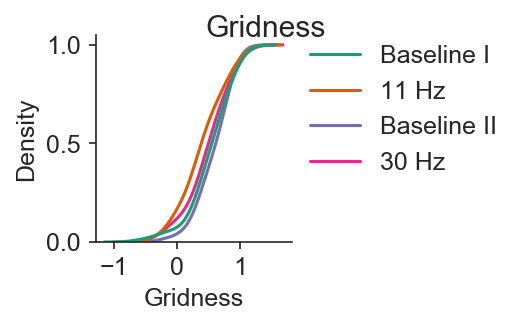

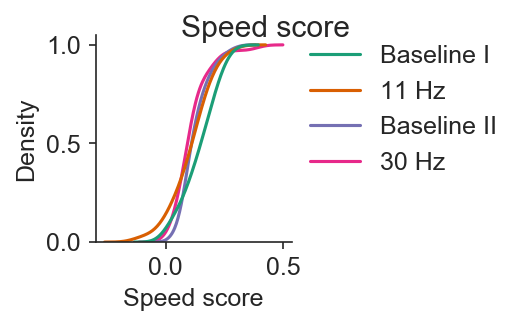

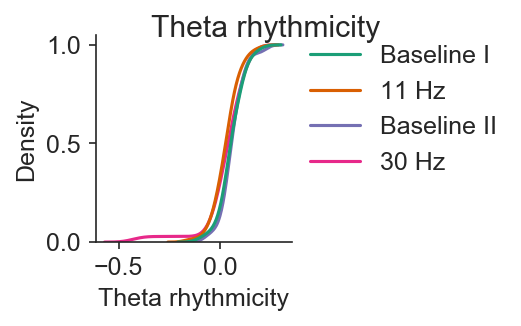

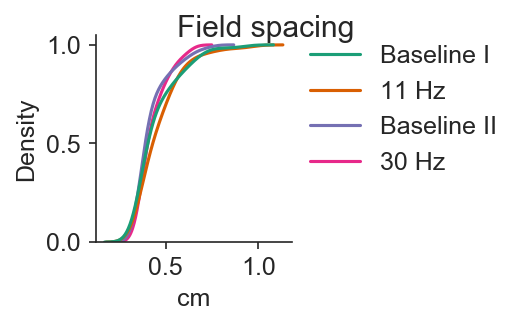

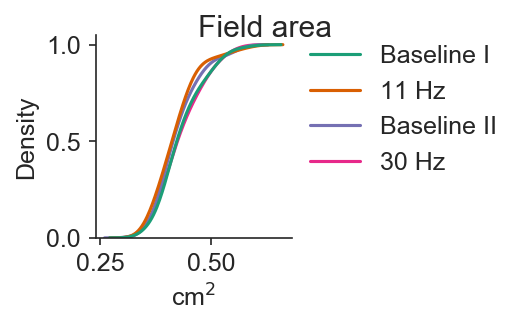

In [33]:
title_xlabel = {
    'information_rate': ('Spatial information','bits/spike'),
    'information_specificity': ("Spatial information specificity","bits/spike"),
    'specificity': ("Spatial specificity", ""),
    'average_rate': ("Average rate", "spikes/s"),
    'max_rate': ("Max rate", "spikes/s"),
    'interspike_interval_cv': ("ISI CV", "Coefficient of variation"),
    'in_field_mean_rate': ("In-field rate", "spikes/s"),
    'out_field_mean_rate': ("Out-of-field rate", "spikes/s"),
    'burst_event_ratio': ("Bursting ratio", ""),
    'gridness': ("Gridness", "Gridness"),
    'speed_score': ("Speed score", "Speed score"),
    'theta_score': ('Theta rhythmicity', 'Theta rhythmicity'),
    'spacing': ('Field spacing', 'cm'),
    'field_area': ('Field area', 'cm$^2$'),
}
for key in title_xlabel:
    fig = plt.figure()
    plt.suptitle(title_xlabel[key][0])
    legend_lines = []
    for color, label in zip(colors, labels):
        legend_lines.append(matplotlib.lines.Line2D([0], [0], color=color, label=label))
    sns.kdeplot(data=results[key].loc[:,labels], cumulative=True, legend=False, palette=colors, common_norm=False)
    plt.xlabel(title_xlabel[key][1])
    plt.legend(
        handles=legend_lines,
        bbox_to_anchor=(1.04,1), borderaxespad=0, frameon=False)
    plt.tight_layout()
    plt.grid(False)
    despine()
    savefig(output_path / "figures" / ('cumulative_' + key))

# Violinplot

In [34]:
%matplotlib inline
plt.rc('axes', titlesize=12)
plt.rcParams.update({
    'font.size': 12, 
    'figure.figsize': (1.7*3, 3), 
    'figure.dpi': 150
})

# Information rate

In [35]:
def violinplot(data, xticks, colors):
    pos = [i * 0.6 for i in range(len(data))]
    print(pos)
    violins = plt.violinplot(data, pos, showmedians=True, showextrema=False)
    
    for i, b in enumerate(violins['bodies']):
        b.set_color(colors[i])
        b.set_alpha (0.8)

    # for i, body in enumerate(violins['cbars']):
    #     body.set_color('C{}'.format(i))

    for category in ['cbars', 'cmins', 'cmaxes', 'cmedians']:
        if category in violins:
            violins[category].set_color(['k', 'k'])
            violins[category].set_linewidth(2.0)
    plt.xticks(pos, xticks, rotation=45)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

[0.0, 0.6, 1.2, 1.7999999999999998]
[0.0, 0.6, 1.2, 1.7999999999999998]
[0.0, 0.6, 1.2, 1.7999999999999998]
[0.0, 0.6, 1.2, 1.7999999999999998]
[0.0, 0.6, 1.2, 1.7999999999999998]
[0.0, 0.6, 1.2, 1.7999999999999998]
[0.0, 0.6, 1.2, 1.7999999999999998]
[0.0, 0.6, 1.2, 1.7999999999999998]
[0.0, 0.6, 1.2, 1.7999999999999998]
[0.0, 0.6, 1.2, 1.7999999999999998]
[0.0, 0.6, 1.2, 1.7999999999999998]
[0.0, 0.6, 1.2, 1.7999999999999998]
[0.0, 0.6, 1.2, 1.7999999999999998]
[0.0, 0.6, 1.2, 1.7999999999999998]


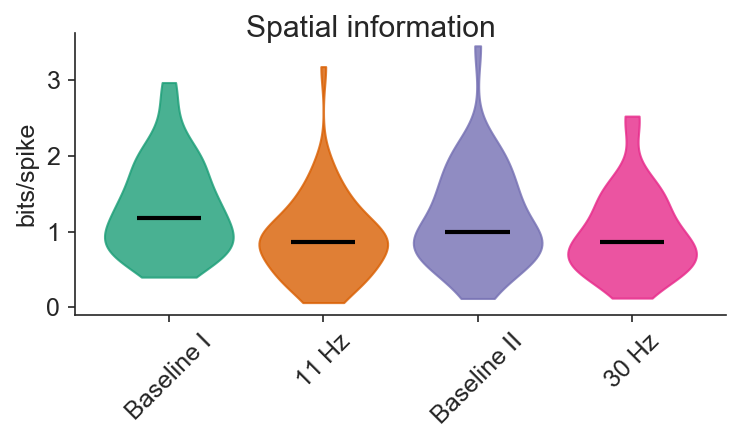

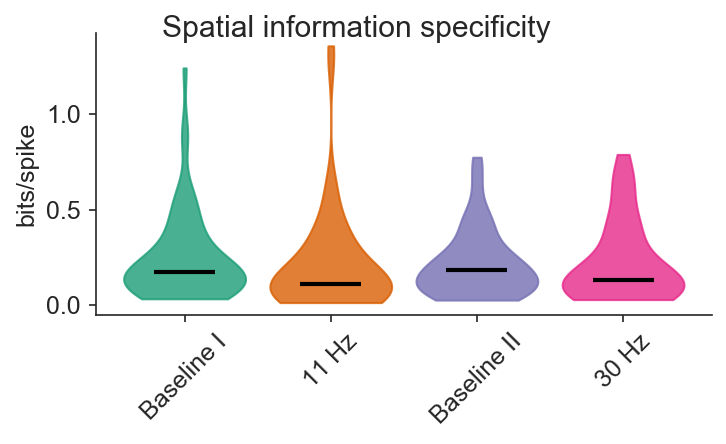

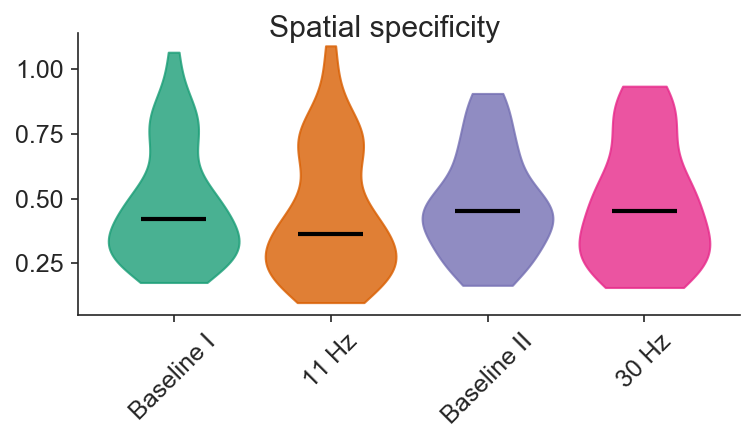

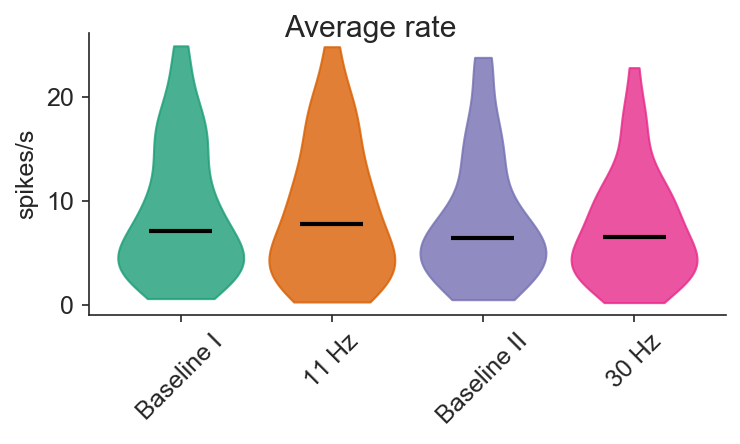

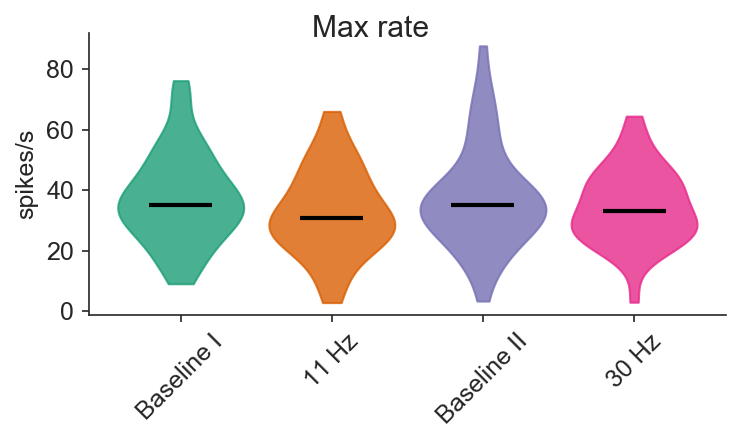

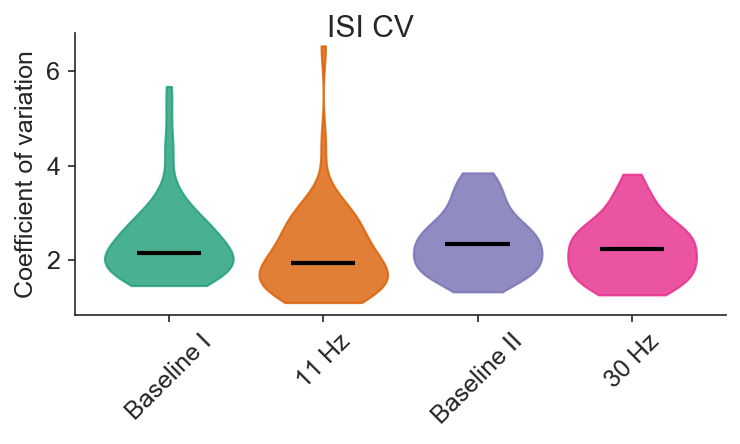

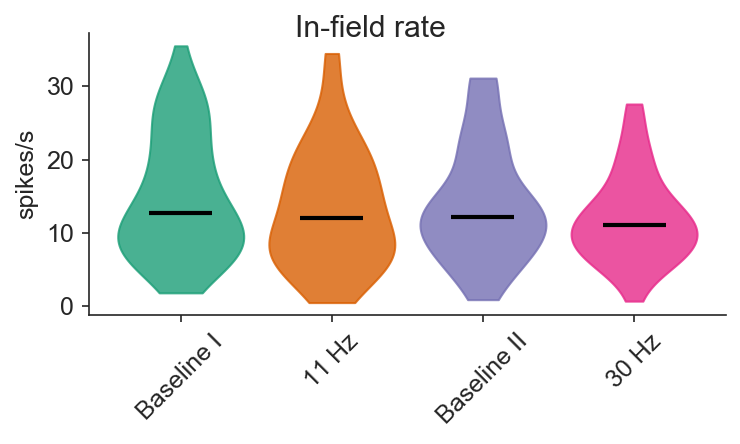

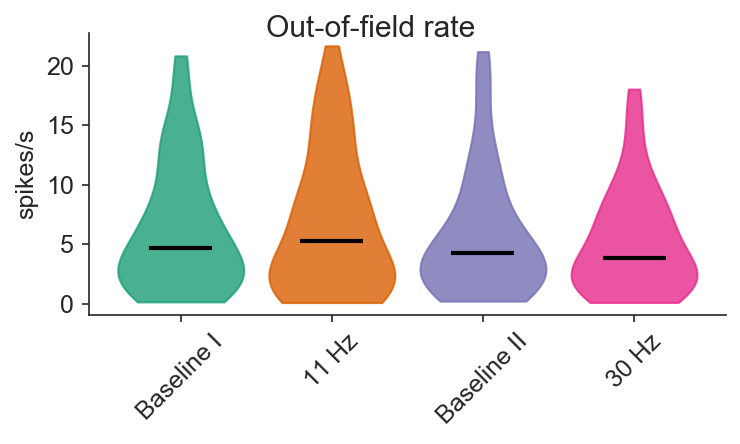

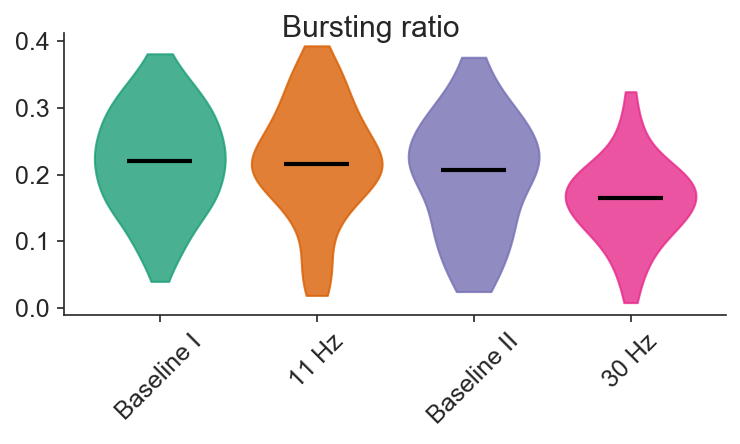

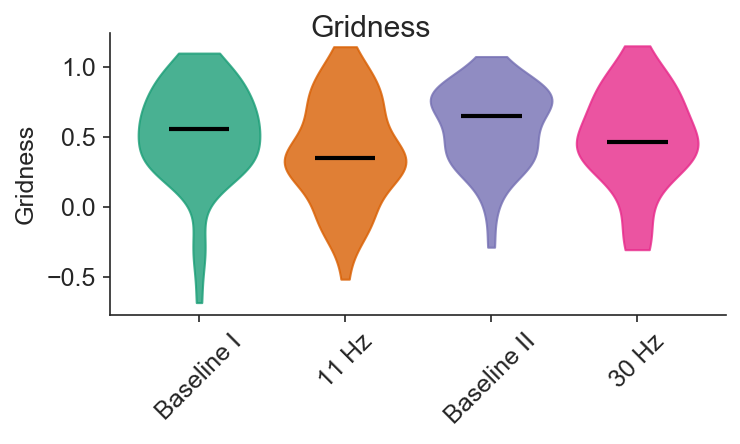

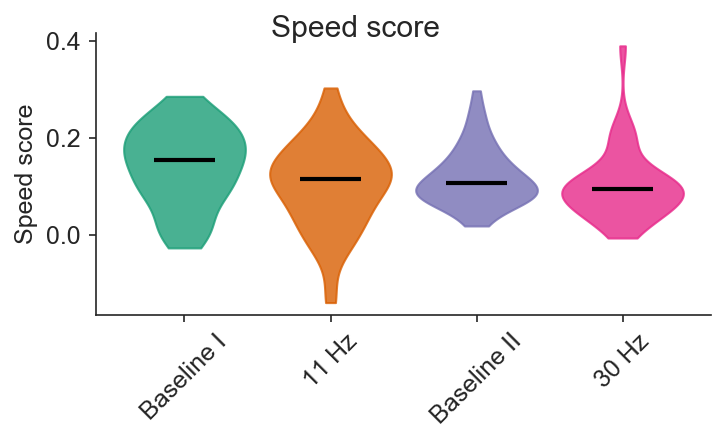

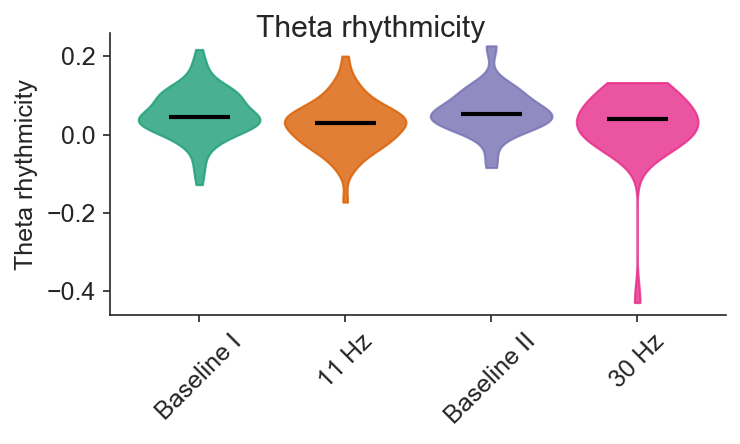

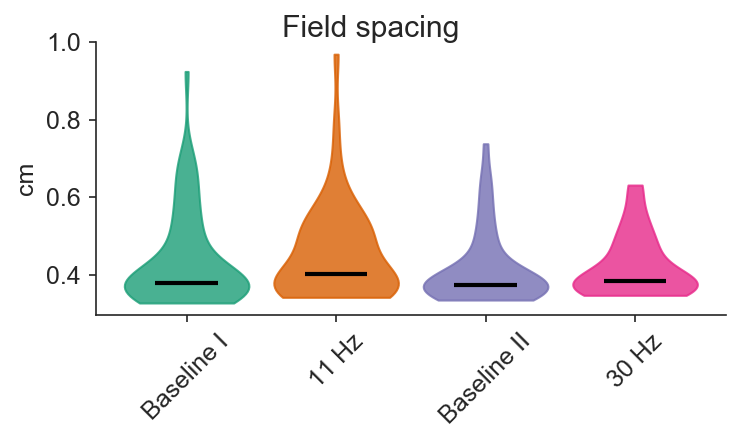

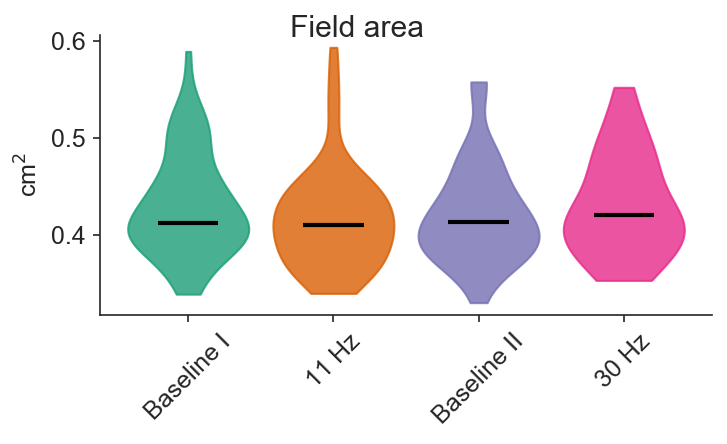

In [36]:
for key in title_xlabel:
    fig = plt.figure()
    plt.suptitle(title_xlabel[key][0])
    violinplot([results[key].loc[:,label].dropna().to_numpy() for label in labels], xticks=labels, colors=colors)
    plt.ylabel(title_xlabel[key][1])
    plt.tight_layout()
    plt.grid(False)
    despine()
    savefig(output_path / "figures" / ('violin_' + key))

# Register in Expipe

In [37]:
action = project.require_action("comparisons-gridcells")

In [38]:
copy_tree(output_path, str(action.data_path()))

['/media/storage/expipe/septum-mec/actions/comparisons-gridcells/data/statistics/values_burst_event_ratio.csv',
 '/media/storage/expipe/septum-mec/actions/comparisons-gridcells/data/statistics/values_in_field_mean_rate.csv',
 '/media/storage/expipe/septum-mec/actions/comparisons-gridcells/data/statistics/values_gridness.csv',
 '/media/storage/expipe/septum-mec/actions/comparisons-gridcells/data/statistics/values_field_area.csv',
 '/media/storage/expipe/septum-mec/actions/comparisons-gridcells/data/statistics/values_selectivity.csv',
 '/media/storage/expipe/septum-mec/actions/comparisons-gridcells/data/statistics/values_gridness.tex',
 '/media/storage/expipe/septum-mec/actions/comparisons-gridcells/data/statistics/values_max_rate.tex',
 '/media/storage/expipe/septum-mec/actions/comparisons-gridcells/data/statistics/values_specificity.csv',
 '/media/storage/expipe/septum-mec/actions/comparisons-gridcells/data/statistics/values_theta_score.csv',
 '/media/storage/expipe/septum-mec/actions/

In [39]:
septum_mec.analysis.registration.store_notebook(action, "20_comparisons_gridcells.ipynb")